<a href="https://colab.research.google.com/github/Boggis911/PT-Data-Science/blob/main/colab-projects/Mark1_Scan_%26_Filter_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data science

Code requirements:

HUMAN & AI CODING INSTRUCTIONS
- when making changes, change only what is necessary for the given task.


DATA PREPARATION

1. Do not modify original variables:
We must preserve original variables in these 3 data preparation cells:
 - stocks predicted (from txt)
 - stocks traded (from txt)
 - YF stocks predicted (from YF)

 These variables/data frames will be used globally on demand by analysis cells, so they can not be manipulated at any point in the file.



2. Stocks predicted, stocks traded, YF stocks predicted:
  - must prepare the data for further analysis. None of the analysis cells should modify the data anymore.
  - data preparation cells must rescale both YF and txt (input) mu and sigma to monthly mu and sigma values.
  -  for YF price data, merge data cell must take the forecast date, then calculate end_date, which is 30 calendar days from the forecast day. Effectivelly it should find stock close prices on the forecast day and end_date - then use them to calculate realized_1m value.
  - cells that create reusable dataframes, should define/document the schema within the cell code.




ANALYSIS

1. Mu error
2. Sigma error
3. Correlation
4. portfolio returns
5. portfolio performance
    - percentiles for Yf data should not include SPY and QQQ


RULES
- each cell has to have its name.


### settings

In [ ]:
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)


## Scan & Filter performance

RULES:

YF data import
- YF should get weekly closing prices. The date starts when the scaning/filtering was made (see txt file) and we are interested in the following 8 weeks after the scaning has been made.

### txt import

In [ ]:
### txt import

# CELL: Import new overall-data txt file (whitespace-delimited) with preview
import pandas as pd
from pathlib import Path

# point to your new file(s)
batch_files = [
    "2025-06-15-scan-filter.txt",
    "2025-06-24-filter-only.txt",
    "2025-06-24-scan-filter.txt",
]


dfs = []
for f in batch_files:
    df = pd.read_csv(f, delim_whitespace=True, dtype=str)

    # normalize columns
    df.columns = [c.strip() for c in df.columns]
    # enforce required columns
    req = {"Date","Ticker","Sector","Filter_mu","Filter_mu_se","Filter_sigma",
           "Scanner_mu","Scanner_mu_se","Scanner_sigma"}
    missing = req - set(df.columns)
    if missing:
        raise ValueError(f"{f} missing columns: {sorted(missing)}")

    # types
    df["Date"] = pd.to_datetime(df["Date"])
    for col in ["Filter_mu","Filter_mu_se","Filter_sigma",
                "Scanner_mu","Scanner_mu_se","Scanner_sigma"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # flags expected downstream
    df["In_Filter"] = df["Filter_mu"].notna().map({True:"Yes", False:"No"})
    df["In_Scan"]   = df["Scanner_mu"].notna().map({True:"Yes", False:"No"})

    # keep only columns the downstream code expects, plus originals if needed
    df = df[["Date","Ticker","In_Scan","In_Filter","Sector",
             "Filter_mu","Filter_mu_se","Filter_sigma",
             "Scanner_mu","Scanner_mu_se","Scanner_sigma"]]

    df["Ticker"] = df["Ticker"].astype(str).str.strip().str.upper()
    df["Batch_ID"] = Path(f).stem
    dfs.append(df)

    print(f"\nPreview for {f}:")
    print(df.head())
    print(f"Rows: {len(df)} | Unique tickers: {df['Ticker'].nunique()}")

scan_filter = pd.concat(dfs, ignore_index=True)

print("\nTotal batches loaded:", scan_filter['Batch_ID'].nunique())
print("Total rows:", len(scan_filter))



Preview for 2025-06-15-scan-filter.txt:
        Date Ticker In_Scan In_Filter      Sector  Filter_mu  Filter_mu_se  Filter_sigma  Scanner_mu  Scanner_mu_se  Scanner_sigma                Batch_ID
0 2025-06-16    XRP     Yes       Yes      crypto       15.0          10.0          60.0       120.0           60.0           90.0  2025-06-15-scan-filter
1 2025-06-16   APLD     Yes       Yes          IT       20.0          15.0         100.0        90.0           45.0           80.0  2025-06-15-scan-filter
2 2025-06-16   OSCR     Yes       Yes  Financials       15.0           5.0          50.0        85.0           30.0           70.0  2025-06-15-scan-filter
3 2025-06-16    SOL     Yes       Yes      crypto       20.0          15.0          70.0        80.0           40.0           75.0  2025-06-15-scan-filter
4 2025-06-16     HP     Yes        No      Energy        NaN           NaN           NaN        75.0           30.0           60.0  2025-06-15-scan-filter
Rows: 32 | Unique tickers: 32

/tmp/ipython-input-2517812659.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(f, delim_whitespace=True, dtype=str)
/tmp/ipython-input-2517812659.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(f, delim_whitespace=True, dtype=str)
/tmp/ipython-input-2517812659.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(f, delim_whitespace=True, dtype=str)


### YF data fetch

In [ ]:
# CELL: Download YF prices (per-batch, with parallel per-ticker fallback)
import pandas as pd, numpy as np, time
import yfinance as yf
from concurrent.futures import ThreadPoolExecutor, as_completed

def _close_view(px: pd.DataFrame) -> pd.DataFrame:
    if "Adj Close" in px:
        out = px["Adj Close"].copy()
    elif "Close" in px:
        out = px["Close"].copy()
    else:
        out = px.copy()
    # drop MultiIndex if present
    if isinstance(out.columns, pd.MultiIndex):
        out.columns = out.columns.droplevel(0)
    return out

TODAY = pd.Timestamp.today().normalize()
MAX_WORKERS = 8
RETRIES = 2
SLEEP_BASE = 0.6

SKIP = {"FSR"}  # dead symbols
REMAP = {
    "BTC":"BTC-USD",
    "ETH":"ETH-USD",
    "XRP":"XRP-USD",
    "SOL":"SOL-USD",   # Solana crypto
    "SOL_E":"SOL",     # Emeren Group stock
}

def _dl_batch(tickers, start_date, end_date):
    try:
        raw = yf.download(
            tickers=tickers,
            start=str(start_date.date()),
            end=str(end_date.date()),
            interval="1d",
            auto_adjust=True,
            progress=False,
            group_by="column",
            threads=True,
        )
        return _close_view(raw)
    except Exception:
        return pd.DataFrame()

def _dl_one(t, start_date, end_date):
    for k in range(RETRIES+1):
        try:
            r = yf.download(
                tickers=t,
                start=str(start_date.date()),
                end=str(end_date.date()),
                interval="1d",
                auto_adjust=True,
                progress=False,
                group_by="column",
                threads=False,
            )
            cv = _close_view(r)
            if isinstance(cv, pd.Series):
                cv = cv.to_frame(name=t)
            if t in cv.columns and not cv[t].dropna().empty:
                return cv[[t]]
        except Exception:
            pass
        time.sleep(SLEEP_BASE * (2**k))
    return pd.DataFrame()

raw_price_data = []

for bid, d in scan_filter[["Batch_ID","Date"]].drop_duplicates().itertuples(index=False):
    start_date = pd.Timestamp(d).normalize()
    end_date = TODAY + pd.Timedelta(days=1)

    batch_tickers = (
        scan_filter.loc[scan_filter["Batch_ID"]==bid, "Ticker"]
        .astype(str).str.strip().str.upper().tolist()
    )
    alias = {t: REMAP.get(t, t) for t in batch_tickers if t not in SKIP}
    dl_tickers = sorted(set(alias.values()))
    print(f"\nBatch {bid}: {len(batch_tickers)} tickers -> {len(dl_tickers)} after remap/skip {start_date.date()}→{end_date.date()}")

    # try batch
    px = _dl_batch(dl_tickers, start_date, end_date)
    got_cols = [c for c in getattr(px, "columns", []) if c in dl_tickers]
    sufficient = len(got_cols) >= max(2, int(0.5*len(dl_tickers)))

    # parallel per-ticker fallback
    if px.empty or not sufficient:
        per_list, failed = [], []
        with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
            fut = {ex.submit(_dl_one, t, start_date, end_date): t for t in dl_tickers}
            for f in as_completed(fut):
                t = fut[f]
                df = f.result()
                if df.empty: failed.append(t)
                else: per_list.append(df)
        px = (pd.concat(per_list, axis=1).sort_index() if per_list else pd.DataFrame())
        if failed:
            print(f"  Per-ticker failures: {failed}")

    if px.empty:
        print("  No valid prices returned.")
        continue

    # inverse alias map
    inv_alias = {}
    for orig, dl in alias.items():
        inv_alias.setdefault(dl, set()).add(orig)

    cols = [c for c in px.columns if c in dl_tickers]
    px = px.loc[:, cols]
    px_reset = px.reset_index().rename(columns={"index":"Date"})

    long_chunks = []
    for dl in cols:
        vals = px_reset[["Date", dl]].rename(columns={dl:"close"})
        for orig in sorted(inv_alias.get(dl, {dl})):
            tmp = vals.copy()
            tmp["Ticker"] = orig   # use capitalized to match scan_filter
            tmp["scan_date"] = start_date
            tmp["Batch_ID"] = bid
            long_chunks.append(tmp)

    long = pd.concat(long_chunks, ignore_index=True)
    raw_price_data.append(long)
    print(f"  Rows: {len(long)} | Tickers with data: {long['Ticker'].nunique()}")

yf_scan_filter_prices = pd.concat(raw_price_data, ignore_index=True) if raw_price_data else pd.DataFrame()
print("\nFinal YF table:")
print("Shape:", yf_scan_filter_prices.shape)
print(yf_scan_filter_prices.head())
print("Unique tickers:", yf_scan_filter_prices["Ticker"].nunique() if not yf_scan_filter_prices.empty else 0)
print("Unique batches:", yf_scan_filter_prices["Batch_ID"].nunique() if not yf_scan_filter_prices.empty else 0)



Batch 2025-06-15-scan-filter: 32 tickers -> 32 after remap/skip 2025-06-16→2025-10-03
  Rows: 3488 | Tickers with data: 32

Batch 2025-06-24-filter-only: 13 tickers -> 13 after remap/skip 2025-06-24→2025-10-03
  Rows: 1313 | Tickers with data: 13

Batch 2025-06-24-scan-filter: 17 tickers -> 17 after remap/skip 2025-06-24→2025-10-03
  Rows: 1190 | Tickers with data: 17

Final YF table:
Shape: (5991, 5)
Ticker       Date       close Ticker  scan_date                Batch_ID
0      2025-06-16  198.195068   AAPL 2025-06-16  2025-06-15-scan-filter
1      2025-06-17  195.418213   AAPL 2025-06-16  2025-06-15-scan-filter
2      2025-06-18  196.357147   AAPL 2025-06-16  2025-06-15-scan-filter
3      2025-06-19         NaN   AAPL 2025-06-16  2025-06-15-scan-filter
4      2025-06-20  200.772141   AAPL 2025-06-16  2025-06-15-scan-filter
Unique tickers: 49
Unique batches: 3


### baseline SPY

In [ ]:
# CELL: SPY baseline — weekly and monthly returns from scan dates through today
import pandas as pd, numpy as np
import yfinance as yf

TODAY = pd.Timestamp.today().normalize()

rows_wk, rows_mo = [], []

for scan_date in pd.to_datetime(scan_filter["Date"].unique()):
    start_date = scan_date
    end_date   = TODAY + pd.Timedelta(days=1)   # inclusive of today

    raw = yf.download(
        tickers="SPY",
        start=str(start_date.date()),
        end=str(end_date.date()),  # end is exclusive
        auto_adjust=True,
        progress=False,
        group_by="column"
    )
    if raw.empty:
        continue

    bench_close = raw["Adj Close"] if "Adj Close" in raw else raw["Close"]

    # --- weekly returns ---
    weekly_px  = bench_close.resample("W-FRI").last().dropna()
    weekly_ret = weekly_px.pct_change().dropna() * 100
    for i, d in enumerate(weekly_ret.index, start=1):
        rows_wk.append({
            "scan_date": start_date,
            "week": i,
            "week_ending": d,
            "SPY_Weekly_Return": float(weekly_ret.loc[d])
        })

    # --- monthly (4-week) returns ---
    # define 4-week intervals from scan_date
    idx_targets = [scan_date + pd.Timedelta(weeks=4*i) for i in range(1, int((TODAY-scan_date).days/7/4)+1)]
    px_aligned = bench_close.reindex(bench_close.index.union(idx_targets)).sort_index().ffill().loc[idx_targets]
    if not px_aligned.empty:
        base = bench_close.loc[bench_close.index >= scan_date].iloc[0]
        for j, d in enumerate(px_aligned.index, start=1):
            ret = (px_aligned.loc[d]/base - 1.0) * 100
            rows_mo.append({
                "scan_date": start_date,
                "month": j,
                "month_ending": d,
                "SPY_Monthly_Return": float(ret)
            })

# assemble DataFrames
spy_weekly = pd.DataFrame(rows_wk)
spy_monthly = pd.DataFrame(rows_mo)

# add μ and σ summaries
spy_weekly_stats = spy_weekly.groupby("scan_date")["SPY_Weekly_Return"].agg(["mean","std"]).rename(columns={"mean":"mu_wk","std":"sigma_wk"})
spy_monthly_stats = spy_monthly.groupby("scan_date")["SPY_Monthly_Return"].agg(["mean","std"]).rename(columns={"mean":"mu_mo","std":"sigma_mo"})

print("spy_weekly (first few rows):")
print(spy_weekly.head())
print("\nspy_monthly (first few rows):")
print(spy_monthly.head())
print("\nWeekly stats (μ,σ):")
print(spy_weekly_stats.head())
print("\nMonthly stats (μ,σ):")
print(spy_monthly_stats.head())


spy_weekly (first few rows):
   scan_date  week week_ending  SPY_Weekly_Return
0 2025-06-16     1  2025-06-27           3.471423
1 2025-06-16     2  2025-07-04           1.696187
2 2025-06-16     3  2025-07-11          -0.275055
3 2025-06-16     4  2025-07-18           0.635009
4 2025-06-16     5  2025-07-25           1.516934

spy_monthly (first few rows):
   scan_date  month month_ending  SPY_Monthly_Return
0 2025-06-16      1   2025-07-14            3.978413
1 2025-06-16      2   2025-08-11            5.827296
2 2025-06-16      3   2025-09-08            7.975731
3 2025-06-24      1   2025-07-22            3.638875
4 2025-06-24      2   2025-08-19            5.443485

Weekly stats (μ,σ):
               mu_wk  sigma_wk
scan_date                     
2025-06-16  0.814392  1.363274
2025-06-24  0.624604  1.191481

Monthly stats (μ,σ):
               mu_mo  sigma_mo
scan_date                     
2025-06-16  5.927147  2.000529
2025-06-24  5.951080  2.603385


/tmp/ipython-input-3322068188.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "SPY_Weekly_Return": float(weekly_ret.loc[d])
/tmp/ipython-input-3322068188.py:49: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "SPY_Monthly_Return": float(ret)
/tmp/ipython-input-3322068188.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "SPY_Weekly_Return": float(weekly_ret.loc[d])
/tmp/ipython-input-3322068188.py:49: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "SPY_Monthly_Return": float(ret)


### mu accuracy
(Scan, Filter, realized)
Tickers: scan and filter overlaps only

#### data prep

In [ ]:
# CELL — Data prep for overlap: 1M/2M/3M predicted vs realized (robust)
import pandas as pd, numpy as np

# Inputs:
# - scan_filter: ["Batch_ID","Date","Ticker","Sector","In_Scan","In_Filter",
#                 "Filter_mu","Filter_mu_se","Filter_sigma",
#                 "Scanner_mu","Scanner_mu_se","Scanner_sigma"]    # 6M in %
# - yf_scan_filter_prices: ["Date","close","Ticker","scan_date","Batch_ID"]

# 1) Keep strict overlap (both Scan & Filter present)
sf = scan_filter.copy()
sf = sf[(sf["In_Scan"] == "Yes") & (sf["In_Filter"] == "Yes")].copy()

# 2) Convert 6M μ,σ from % → decimals
for c in ["Filter_mu","Filter_mu_se","Filter_sigma",
          "Scanner_mu","Scanner_mu_se","Scanner_sigma"]:
    sf[c] = pd.to_numeric(sf[c], errors="coerce") / 100.0

# 3) Rescale predictions to 1M, 2M, 3M (μ linear in time, σ ∝ sqrt(time))
def _rescale(mu_6m, sig_6m, months):
    t = months / 6.0
    return mu_6m * t, sig_6m * np.sqrt(t)

for m in (1, 2, 3):
    sf[f"Scan_mu_{m}m"],   sf[f"Scan_sigma_{m}m"]   = _rescale(sf["Scanner_mu"], sf["Scanner_sigma"], m)
    sf[f"Filter_mu_{m}m"], sf[f"Filter_sigma_{m}m"] = _rescale(sf["Filter_mu"],  sf["Filter_sigma"],  m)

# 4) Robust realized returns at 1M/2M/3M: nearest on/after scan and on/before target
px = yf_scan_filter_prices.copy()
px["Date"] = pd.to_datetime(px["Date"])
px["scan_date"] = pd.to_datetime(px["scan_date"])
px = px.sort_values(["Batch_ID","Ticker","Date"]).dropna(subset=["close"])

def _realized_to_horizon(g: pd.DataFrame, months: int) -> float:
    sd = g["scan_date"].iloc[0]
    start = g[g["Date"] >= sd]
    if start.empty:
        return np.nan
    p0 = float(start.iloc[0]["close"])
    target = sd + pd.DateOffset(months=months)
    end = g[g["Date"] <= target]
    if end.empty:
        return np.nan
    pT = float(end.iloc[-1]["close"])
    return pT / p0 - 1.0

real = (
    px.groupby(["Batch_ID","Ticker"], as_index=False)
      .apply(lambda gg: pd.Series({
          "Real_mu_1m": _realized_to_horizon(gg, 1),
          "Real_mu_2m": _realized_to_horizon(gg, 2),
          "Real_mu_3m": _realized_to_horizon(gg, 3),
      }))
      .reset_index(drop=True)
)

# 5) Merge predictions with realized; require at least 1M realized
df_eval = (
    sf.merge(real, on=["Batch_ID","Ticker"], how="inner")
      .dropna(subset=["Real_mu_1m"])
)

# 6) Debug preview
cols_show = ["Batch_ID","Date","Ticker","Sector",
             "Scan_mu_1m","Filter_mu_1m","Real_mu_1m","Scan_sigma_1m","Filter_sigma_1m",
             "Scan_mu_2m","Filter_mu_2m","Real_mu_2m","Scan_sigma_2m","Filter_sigma_2m",
             "Scan_mu_3m","Filter_mu_3m","Real_mu_3m","Scan_sigma_3m","Filter_sigma_3m"]
print("df_eval (overlap only) preview:")
print(df_eval[cols_show].head().to_string(index=False))
print("Rows:", len(df_eval),
      "| Unique tickers:", df_eval["Ticker"].nunique(),
      "| Batches:", df_eval["Batch_ID"].nunique())


df_eval (overlap only) preview:
              Batch_ID       Date Ticker     Sector  Scan_mu_1m  Filter_mu_1m  Real_mu_1m  Scan_sigma_1m  Filter_sigma_1m  Scan_mu_2m  Filter_mu_2m  Real_mu_2m  Scan_sigma_2m  Filter_sigma_2m  Scan_mu_3m  Filter_mu_3m  Real_mu_3m  Scan_sigma_3m  Filter_sigma_3m
2025-06-15-scan-filter 2025-06-16    XRP     crypto    0.200000      0.025000    0.356697       0.367423         0.244949    0.400000      0.050000    0.386466       0.519615         0.346410       0.600         0.075    0.355398       0.636396         0.424264
2025-06-15-scan-filter 2025-06-16   APLD         IT    0.150000      0.033333   -0.129004       0.326599         0.408248    0.300000      0.066667    0.219913       0.461880         0.577350       0.450         0.100    0.684848       0.565685         0.707107
2025-06-15-scan-filter 2025-06-16   OSCR Financials    0.141667      0.025000    0.026756       0.285774         0.204124    0.283333      0.050000    0.046154       0.404145        

/tmp/ipython-input-3114509538.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda gg: pd.Series({


#### plots

Summary (means and SEs; SE only for Realized):
Horizon Distribution  μ_mean   μ_SE  σ_mean   σ_SE  N
     1M         Scan  0.1059    NaN  0.1875    NaN 32
     1M       Filter  0.0197    NaN  0.1563    NaN 32
     1M     Realized  0.1036 0.0256  0.1450 0.0184 32
     2M         Scan  0.2119    NaN  0.2652    NaN 32
     2M       Filter  0.0395    NaN  0.2210    NaN 32
     2M     Realized  0.1360 0.0306  0.1729 0.0220 32
     3M         Scan  0.3178    NaN  0.3248    NaN 32
     3M       Filter  0.0592    NaN  0.2707    NaN 32
     3M     Realized  0.2213 0.0501  0.2832 0.0360 32


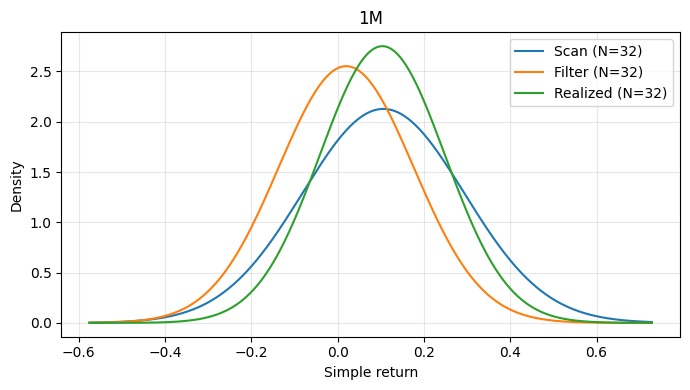

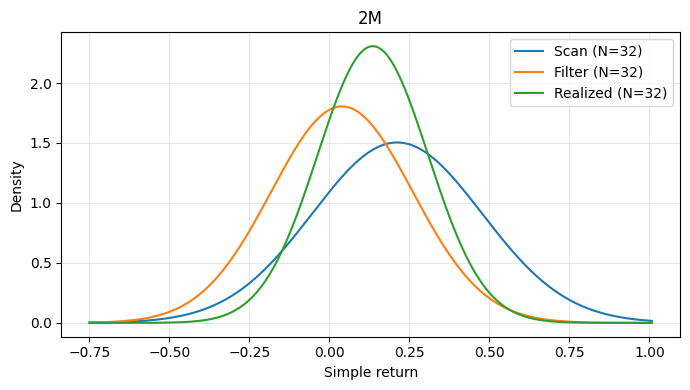

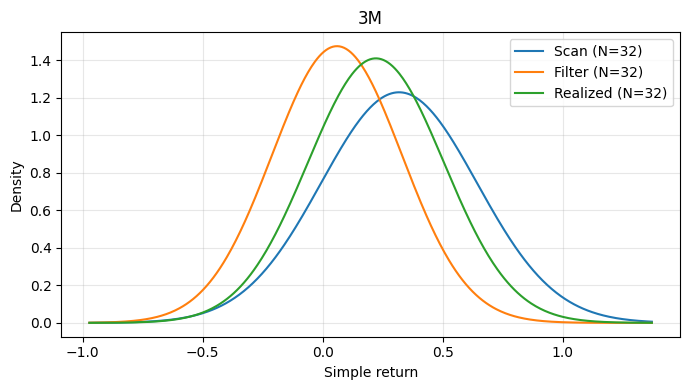

In [ ]:
# CELL 2 — Summary table with mean/SE columns + overlays (1M/2M/3M)

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from math import sqrt, pi

def _norm_pdf(x, mu, sigma):
    if not np.isfinite(mu) or not np.isfinite(sigma) or sigma <= 0:
        return np.zeros_like(x)
    return (1.0/(sigma*sqrt(2*pi))) * np.exp(-0.5*((x-mu)/sigma)**2)

def _se_mean(sd, n):           # SE of mean
    return sd / np.sqrt(n) if n and np.isfinite(sd) else np.nan

def _se_sigma(sd, n):          # approx SE of SD under normality
    return sd / np.sqrt(2*(n-1)) if n and n > 1 and np.isfinite(sd) else np.nan

def _nz(series):
    return pd.to_numeric(series, errors="coerce").dropna()

# ---- build summary with separate mean / SE columns
rows = []
for H, key in [("1M","1m"), ("2M","2m"), ("3M","3m")]:
    mu_scan_s = _nz(df_eval[f"Scan_mu_{key}"])
    mu_filt_s = _nz(df_eval[f"Filter_mu_{key}"])
    mu_real_s = _nz(df_eval[f"Real_mu_{key}"])

    sg_scan_s = _nz(df_eval[f"Scan_sigma_{key}"])
    sg_filt_s = _nz(df_eval[f"Filter_sigma_{key}"])

    # realized sigma is SD of realized μ distribution
    real_sd   = mu_real_s.std(ddof=1)
    n_real    = len(mu_real_s)

    rows += [
        {"Horizon":H,"Distribution":"Scan",
         "μ_mean":mu_scan_s.mean(), "μ_SE":np.nan,
         "σ_mean":sg_scan_s.mean(), "σ_SE":np.nan,
         "N":len(mu_scan_s)},
        {"Horizon":H,"Distribution":"Filter",
         "μ_mean":mu_filt_s.mean(), "μ_SE":np.nan,
         "σ_mean":sg_filt_s.mean(), "σ_SE":np.nan,
         "N":len(mu_filt_s)},
        {"Horizon":H,"Distribution":"Realized",
         "μ_mean":mu_real_s.mean(), "μ_SE":_se_mean(real_sd, n_real),
         "σ_mean":real_sd,          "σ_SE":_se_sigma(real_sd, n_real),
         "N":n_real},
    ]

summary = pd.DataFrame(rows)[
    ["Horizon","Distribution","μ_mean","μ_SE","σ_mean","σ_SE","N"]
]
print("Summary (means and SEs; SE only for Realized):")
print(summary.round(4).to_string(index=False))

# ---- overlay plots with N in legends
def _plot_overlay(title, key):
    mu_scan = _nz(df_eval[f"Scan_mu_{key}"]).mean()
    mu_filt = _nz(df_eval[f"Filter_mu_{key}"]).mean()
    real_s  = _nz(df_eval[f"Real_mu_{key}"])
    sig_scan= _nz(df_eval[f"Scan_sigma_{key}"]).mean()
    sig_filt= _nz(df_eval[f"Filter_sigma_{key}"]).mean()

    real_mu = real_s.mean()
    real_sd = real_s.std(ddof=1)

    n_scan = int(summary.query("Horizon==@title & Distribution=='Scan'")["N"].iloc[0])
    n_filt = int(summary.query("Horizon==@title & Distribution=='Filter'")["N"].iloc[0])
    n_real = int(summary.query("Horizon==@title & Distribution=='Realized'")["N"].iloc[0])

    base_mu = np.nanmean([real_mu, mu_scan, mu_filt])
    base_sd = np.nanmean([real_sd, sig_scan, sig_filt])
    if not np.isfinite(base_sd) or base_sd <= 0: base_sd = 0.05
    x = np.linspace(base_mu - 4*base_sd, base_mu + 4*base_sd, 500)

    plt.figure(figsize=(7,4))
    plt.plot(x, _norm_pdf(x, mu_scan, sig_scan), label=f"Scan (N={n_scan})")
    plt.plot(x, _norm_pdf(x, mu_filt, sig_filt), label=f"Filter (N={n_filt})")
    plt.plot(x, _norm_pdf(x, real_mu, real_sd), label=f"Realized (N={n_real})")
    plt.title(title)
    plt.xlabel("Simple return")
    plt.ylabel("Density")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

_plot_overlay("1M", "1m")
_plot_overlay("2M", "2m")
_plot_overlay("3M", "3m")


### Correlation

#### data

In [ ]:
# CELL — Data prep for correlation analysis (Scan + Filter)

import pandas as pd, numpy as np

parts = []
for H in ("1M","2M","3M"):
    key = H.lower()
    # Scan
    parts.append(pd.DataFrame({
        "Horizon": H, "Source": "Scan",
        "Batch_ID": df_eval["Batch_ID"], "Ticker": df_eval["Ticker"],
        "mu_pred": df_eval[f"Scan_mu_{key}"],
        "sigma_pred": df_eval[f"Scan_sigma_{key}"],
        "mu_real": df_eval[f"Real_mu_{key}"],
    }))
    # Filter
    parts.append(pd.DataFrame({
        "Horizon": H, "Source": "Filter",
        "Batch_ID": df_eval["Batch_ID"], "Ticker": df_eval["Ticker"],
        "mu_pred": df_eval[f"Filter_mu_{key}"],
        "sigma_pred": df_eval[f"Filter_sigma_{key}"],
        "mu_real": df_eval[f"Real_mu_{key}"],
    }))

df_corr = pd.concat(parts, ignore_index=True)
df_corr = df_corr.dropna(subset=["mu_pred","mu_real"])
df_corr = df_corr.sort_values(["Horizon","Source","mu_pred"], ascending=[True,True,False])
df_corr["rank"] = df_corr.groupby(["Horizon","Source"])["mu_pred"].rank(method="first", ascending=False).astype(int)

print("df_corr preview:")
print(df_corr.head(12))


df_corr preview:
   Horizon  Source                Batch_ID Ticker   mu_pred  sigma_pred   mu_real  rank
47      1M  Filter  2025-06-24-scan-filter   MRNA  0.050000    0.163299  0.269030     1
53      1M  Filter  2025-06-24-scan-filter    CZR  0.041667    0.122474 -0.032084     2
33      1M  Filter  2025-06-15-scan-filter   APLD  0.033333    0.408248 -0.129004     3
35      1M  Filter  2025-06-15-scan-filter    SOL  0.033333    0.285774  0.151379     4
36      1M  Filter  2025-06-15-scan-filter   SOFI  0.033333    0.204124  0.435570     5
49      1M  Filter  2025-06-24-scan-filter   FSLR  0.033333    0.122474  0.195396     6
60      1M  Filter  2025-06-24-scan-filter    MGM  0.033333    0.122474  0.092398     7
32      1M  Filter  2025-06-15-scan-filter    XRP  0.025000    0.244949  0.356697     8
34      1M  Filter  2025-06-15-scan-filter   OSCR  0.025000    0.204124  0.026756     9
40      1M  Filter  2025-06-15-scan-filter    BTC  0.025000    0.244949  0.111818    10
54      1M  Fil

#### mu, sigma, corr, percentiles

In [ ]:
# CELL — Percentile slice analysis with correlations for SCAN and FILTER

from scipy.stats import pearsonr, spearmanr
import pandas as pd, numpy as np
import math

def slice_stats_pct(df, pct_list=(0.10, 0.20, 0.50)):
    out = []
    n_all = len(df)
    for p in list(pct_list) + ["All"]:
        if p == "All":
            sub = df
            label = "All"
        else:
            k = max(1, int(math.ceil(p * n_all)))  # at least 1
            sub = df.head(k)
            label = f"Top{int(p*100)}%"
        n = len(sub)
        if n == 0:
            continue

        mu_pred_mean = sub["mu_pred"].mean()
        mu_real_mean = sub["mu_real"].mean()
        mu_real_sd   = sub["mu_real"].std(ddof=1)
        mu_real_se   = mu_real_sd / np.sqrt(n) if n > 0 else np.nan

        sig_pred_mean = sub["sigma_pred"].mean()
        sig_real_sd   = sub["mu_real"].std(ddof=1)
        sig_real_se   = sig_real_sd / np.sqrt(2*(n-1)) if n > 1 else np.nan

        hit_rate = (sub["mu_real"] > 0).mean() if n > 0 else np.nan

        if n > 1:
            pear_r, _  = pearsonr(sub["mu_pred"], sub["mu_real"])
            spear_r, _ = spearmanr(sub["mu_pred"], sub["mu_real"])
        else:
            pear_r = spear_r = np.nan

        out.append({
            "Slice": label,
            "N": n,
            "mu_pred_mean": mu_pred_mean,
            "mu_real_mean": f"{mu_real_mean:.4f} ± {mu_real_se:.4f}",
            "Pred_sigma_mean": sig_pred_mean,
            "Real_sigma": f"{sig_real_sd:.4f} ± {sig_real_se:.4f}",
            "Hit_rate": hit_rate,
            "Pearson_r": pear_r,
            "Spearman_r": spear_r,
        })
    return pd.DataFrame(out)

def run_analysis(mode="Filter", pct_list=(0.10, 0.20, 0.50)):
    print(f"\n===== {mode.upper()}-BASED PREDICTIONS =====")
    for H in ("1M","2M","3M"):
        key = H.lower()
        df_tmp = pd.DataFrame({
            "Horizon": H,
            "mu_pred":   pd.to_numeric(df_eval[f"{mode}_mu_{key}"], errors="coerce"),
            "sigma_pred":pd.to_numeric(df_eval[f"{mode}_sigma_{key}"], errors="coerce"),
            "mu_real":   pd.to_numeric(df_eval[f"Real_mu_{key}"], errors="coerce"),
        }).dropna(subset=["mu_pred","mu_real"])
        df_tmp = df_tmp.sort_values("mu_pred", ascending=False).reset_index(drop=True)

        print(f"\n=== {H} ===")
        table = slice_stats_pct(df_tmp, pct_list=pct_list)
        print(table.to_string(index=False))

# Run both Scan and Filter blocks (edit percentiles as needed)
run_analysis("Scan",   pct_list=(0.10, 0.25, 0.50))
run_analysis("Filter", pct_list=(0.10, 0.25, 0.50))



===== SCAN-BASED PREDICTIONS =====

=== 1M ===
 Slice  N  mu_pred_mean    mu_real_mean  Pred_sigma_mean      Real_sigma  Hit_rate  Pearson_r  Spearman_r
Top10%  4      0.162500 0.1309 ± 0.1112         0.295980 0.2225 ± 0.0908     0.750   0.769778    0.800000
Top25%  8      0.147917 0.0964 ± 0.0627         0.250052 0.1774 ± 0.0474     0.750   0.503071    0.240981
Top50% 16      0.129375 0.1073 ± 0.0325         0.205400 0.1300 ± 0.0237     0.875   0.253339    0.126938
   All 32      0.105937 0.1036 ± 0.0256         0.187539 0.1450 ± 0.0184     0.750   0.262686    0.196881

=== 2M ===
 Slice  N  mu_pred_mean    mu_real_mean  Pred_sigma_mean      Real_sigma  Hit_rate  Pearson_r  Spearman_r
Top10%  4      0.325000 0.1661 ± 0.0864         0.418579 0.1728 ± 0.0706   1.00000   0.798908    0.400000
Top25%  8      0.295833 0.1561 ± 0.0593         0.353627 0.1676 ± 0.0448   0.87500   0.306185   -0.096393
Top50% 16      0.258750 0.1624 ± 0.0344         0.290479 0.1375 ± 0.0251   0.87500   0.15932

#### scatter plot, Scan/Filter; N-month

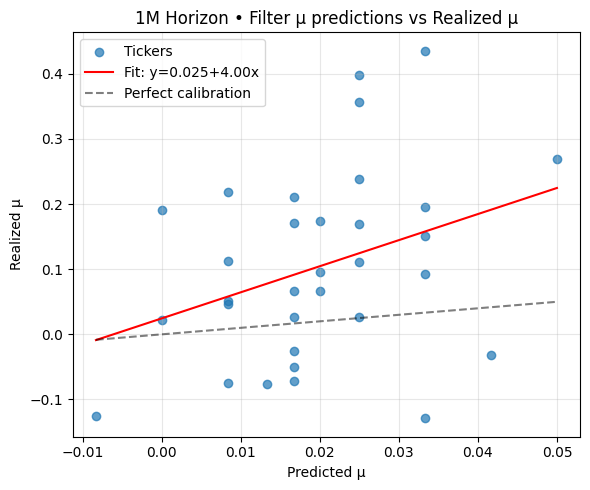

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     4.028
Date:                Thu, 02 Oct 2025   Prob (F-statistic):             0.0538
Time:                        09:17:16   Log-Likelihood:                 18.910
No. Observations:                  32   AIC:                            -33.82
Df Residuals:                      30   BIC:                            -30.89
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0246      0.046      0.530      0.6

In [ ]:
# CELL — Scatter plot of predicted vs realized μ with regression line
# Tune this: choose "1M", "2M", or "3M"
H = "1M"

import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# pick Filter vs Scan here (or run both)
source = "Filter"   # or "Scan"

key = H.lower()
mu_pred = df_eval[f"{source}_mu_{key}"]
mu_real = df_eval[f"Real_mu_{key}"]

mask = mu_pred.notna() & mu_real.notna()
x = mu_pred[mask].values
y = mu_real[mask].values

# regression line
X = sm.add_constant(x)   # add intercept
model = sm.OLS(y, X).fit()
slope = model.params[1]
intercept = model.params[0]

# scatter
plt.figure(figsize=(6,5))
plt.scatter(x, y, alpha=0.7, label="Tickers")
# regression line
xx = np.linspace(x.min(), x.max(), 100)
yy = intercept + slope*xx
plt.plot(xx, yy, "r-", label=f"Fit: y={intercept:.3f}+{slope:.2f}x")
# 45° line
plt.plot(xx, xx, "k--", alpha=0.5, label="Perfect calibration")

plt.title(f"{H} Horizon • {source} μ predictions vs Realized μ")
plt.xlabel("Predicted μ")
plt.ylabel("Realized μ")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(model.summary())


#### sigma correlation

In [ ]:
# CELL — σ calibration table (no correlations)

import pandas as pd, numpy as np

NBINS = 5

def _se_sigma(sd, n):
    return sd/np.sqrt(2*(n-1)) if n and n>1 and np.isfinite(sd) else np.nan

rows = []
for source in ["Scan","Filter"]:
    for H in ("1M","2M","3M"):
        key = H.lower()
        pred_sig = pd.to_numeric(df_eval[f"{source}_sigma_{key}"], errors="coerce")
        real_mu  = pd.to_numeric(df_eval[f"Real_mu_{key}"], errors="coerce")
        df = pd.DataFrame({"pred_sigma": pred_sig, "real_mu": real_mu}).dropna()
        if len(df) < 3:
            continue
        try:
            df["bin"] = pd.qcut(df["pred_sigma"], q=NBINS, labels=False, duplicates="drop")
        except ValueError:
            df["bin"] = pd.qcut(df["pred_sigma"].rank(method="average"), q=NBINS, labels=False)

        for b, g in df.groupby("bin"):
            sd = g["real_mu"].std(ddof=1)
            se = _se_sigma(sd, len(g))

            rows.append({
                "Source": source,
                "Horizon": H,
                "Bin": int(b),
                "N": len(g),
                "Pred_sigma_mean": g["pred_sigma"].mean(),
                "Realized_sigma": sd,
                "Realized_sigma_SE": se,
            })

table = pd.DataFrame(rows)
print("σ calibration table by horizon, source, bin")
print(table.round(4).to_string(index=False))


σ calibration table by horizon, source, bin
Source Horizon  Bin  N  Pred_sigma_mean  Realized_sigma  Realized_sigma_SE
  Scan      1M    0  9           0.1202          0.0626             0.0156
  Scan      1M    1  5           0.1633          0.1113             0.0393
  Scan      1M    2  6           0.1837          0.1413             0.0447
  Scan      1M    3  5           0.2041          0.1626             0.0575
  Scan      1M    4  7           0.2829          0.1949             0.0563
  Scan      2M    0  9           0.1700          0.1252             0.0313
  Scan      2M    1  5           0.2309          0.1844             0.0652
  Scan      2M    2  6           0.2598          0.1422             0.0450
  Scan      2M    3  5           0.2887          0.1879             0.0664
  Scan      2M    4  7           0.4000          0.1936             0.0559
  Scan      3M    0  9           0.2082          0.2081             0.0520
  Scan      3M    1  5           0.2828          0.1504 

#### N-month Scan/Filter sigma plot

/tmp/ipython-input-2331676370.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = df.groupby("bin").apply(


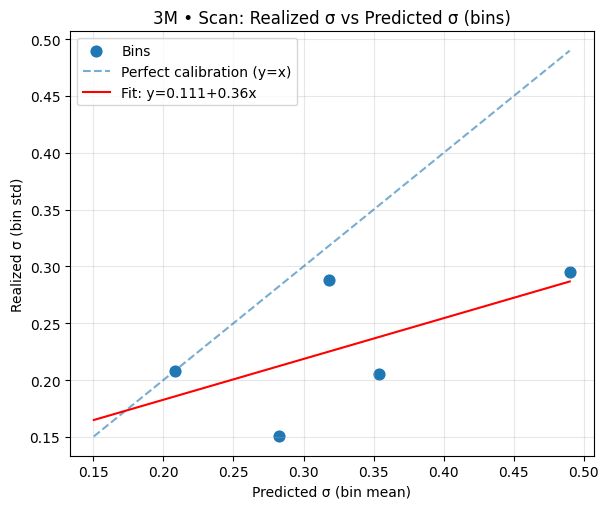

 pred_sigma_mean  realized_sigma
          0.2082          0.2081
          0.2828          0.1504
          0.3182          0.2884
          0.3536          0.2057
          0.4899          0.2950


In [ ]:
# CELL — σ correlation plot by horizon & source
H = "3M"            # "1M" | "2M" | "3M"
source = "Scan"   # "Filter" | "Scan"
NBINS = 5

import numpy as np, pandas as pd, matplotlib.pyplot as plt

key = H.lower()
pred_sig = pd.to_numeric(df_eval[f"{source}_sigma_{key}"], errors="coerce")
real_mu  = pd.to_numeric(df_eval[f"Real_mu_{key}"], errors="coerce")

df = pd.DataFrame({"pred_sigma": pred_sig, "real_mu": real_mu}).dropna()
df["bin"] = pd.qcut(df["pred_sigma"].rank(method="average"), q=NBINS, labels=False)

out = df.groupby("bin").apply(
    lambda g: pd.Series({
        "pred_sigma_mean": g["pred_sigma"].mean(),
        "realized_sigma": g["real_mu"].std(ddof=1)
    })
).reset_index(drop=True)

x = out["pred_sigma_mean"].values
y = out["realized_sigma"].values

# Fit line
slope, intercept = np.polyfit(x, y, 1)

plt.figure(figsize=(6.2,5.2))
plt.scatter(x, y, s=60, label="Bins")
xx = np.linspace(min(x.min(), y.min()), max(x.max(), y.max()), 200)
plt.plot(xx, xx, "--", alpha=0.6, label="Perfect calibration (y=x)")
plt.plot(xx, intercept + slope*xx, "r-", label=f"Fit: y={intercept:.3f}+{slope:.2f}x")

plt.title(f"{H} • {source}: Realized σ vs Predicted σ (bins)")
plt.xlabel("Predicted σ (bin mean)")
plt.ylabel("Realized σ (bin std)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(out.round(4).to_string(index=False))
